# Customer segmentation using clustering
    -Clustering of data is a unsupervised learning methodology which involves classifying the data points into specified no of clusters.

    -Using the attributes which determines the customer's shopping behavior, clusters can be formed.
    
    -K-Means clustering methodology is employed for forming the clusters.

    -PCA(principle component Analysis) reduces the dimensions of the data, reducing the variance.

In [291]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score,calinski_harabasz_score


## Attributes for determining similarity between customers
    -Total amount spent overall

    -Region

    -Average amounts spent on each category

    -Frequency at which the category product is bought


## Data loading

In [292]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")
products = pd.read_csv("Products.csv")

In [293]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [294]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [295]:
data = customers.merge(transactions, on='CustomerID')
data = data.merge(products, on= 'ProductID')

In [296]:
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data = data.drop('Price_x',axis = 1)

In [297]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,ProductName,Category,Price_y
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,SoundWave Cookbook,Books,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,HomeSense Wall Art,Home Decor,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,SoundWave Headphones,Electronics,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,ActiveWear Smartwatch,Electronics,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,TechPro Headphones,Electronics,433.64


# Data Pre Processing

In [300]:
customer_data = data.groupby('CustomerID').agg(
    TotalSpent=('TotalValue','sum'),
    Region=('Region','first'),
    # LastTransaction=('TransactionDate','max'),
).reset_index()
# tenure_data = (pd.Timestamp.now() - data.groupby('CustomerID')['SignupDate'].first()).dt.days.reset_index()
# tenure_data.columns = ['CustomerID', 'Tenure']
# customer_data = customer_data.merge(tenure_data, on='CustomerID')

In [273]:
# customer_data['Regency'] = (pd.Timestamp.now()-customer_data['LastTransaction']).dt.days
# customer_data.drop('LastTransaction',axis = 1,inplace=True)

In [301]:
customer_data.head()

,CustomerID,TotalSpent,Region
0,C0001,3354.52,South America
1,C0002,1862.74,Asia
2,C0003,2725.38,South America
3,C0004,5354.88,South America
4,C0005,2034.24,Asia


In [302]:
categ_freq = data.groupby(['CustomerID','Category']).size().unstack(fill_value=0).reset_index()

In [303]:
categ_freq.head()

Category,CustomerID,Books,Clothing,Electronics,Home Decor
0,C0001,1,0,3,1
1,C0002,0,2,0,2
2,C0003,0,1,1,2
3,C0004,3,0,2,3
4,C0005,0,0,2,1


In [304]:
catg_avg = data.groupby(['CustomerID', 'Category'])['TotalValue'].mean().reset_index()
catg_avg = catg_avg.pivot(index='CustomerID', columns='Category', values='TotalValue').fillna(0)

In [305]:
catg_avg.head()

Category,Books,Clothing,Electronics,Home Decor
CustomerID,,,,
C0001,114.600000,0.00,942.433333,412.620000
C0002,0.000000,512.73,0.000000,418.640000
C0003,0.000000,122.36,1385.200000,608.910000
C0004,629.493333,0.00,677.870000,703.553333
C0005,0.000000,0.00,590.190000,853.860000


In [306]:
customer_data = customer_data.merge(catg_avg,on='CustomerID')
customer_data = customer_data.merge(categ_freq,on='CustomerID')

In [307]:
customer_data.head()

,CustomerID,TotalSpent,Region,Books_x,Clothing_x,Electronics_x,Home Decor_x,Books_y,Clothing_y,Electronics_y,Home Decor_y
0,C0001,3354.52,South America,114.600000,0.00,942.433333,412.620000,1,0,3,1
1,C0002,1862.74,Asia,0.000000,512.73,0.000000,418.640000,0,2,0,2
2,C0003,2725.38,South America,0.000000,122.36,1385.200000,608.910000,0,1,1,2
3,C0004,5354.88,South America,629.493333,0.00,677.870000,703.553333,3,0,2,3
4,C0005,2034.24,Asia,0.000000,0.00,590.190000,853.860000,0,0,2,1


## Feature Engineering
    -Encoding the aggrigates

### It is to be noted that categories has been encoded using frequency encoding
### Region is being encoded using One hot encoding

In [308]:
#Encoding the Region
encoder = OneHotEncoder(sparse_output=False)
values = encoder.fit_transform(customer_data[['Region']])
encoded_df = pd.DataFrame(values,columns=encoder.get_feature_names_out(['Region']))
customer_data = pd.concat([customer_data.drop('Region',axis=1), encoded_df],axis = 1)

In [309]:
customer_data.head()


,CustomerID,TotalSpent,Books_x,Clothing_x,Electronics_x,Home Decor_x,Books_y,Clothing_y,Electronics_y,Home Decor_y,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,3354.52,114.600000,0.00,942.433333,412.620000,1,0,3,1,0.0,0.0,0.0,1.0
1,C0002,1862.74,0.000000,512.73,0.000000,418.640000,0,2,0,2,1.0,0.0,0.0,0.0
2,C0003,2725.38,0.000000,122.36,1385.200000,608.910000,0,1,1,2,0.0,0.0,0.0,1.0
3,C0004,5354.88,629.493333,0.00,677.870000,703.553333,3,0,2,3,0.0,0.0,0.0,1.0
4,C0005,2034.24,0.000000,0.00,590.190000,853.860000,0,0,2,1,1.0,0.0,0.0,0.0


In [310]:
customer_data.describe()

,TotalSpent,Books_x,Clothing_x,Electronics_x,Home Decor_x,Books_y,Clothing_y,Electronics_y,Home Decor_y,Region_Asia,Region_Europe,Region_North America,Region_South America
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,3467.314372,544.241262,511.401128,498.645036,427.902542,1.356784,1.145729,1.276382,1.246231,0.221106,0.251256,0.231156,0.296482
std,1832.677958,488.862817,520.023368,474.261006,401.144029,1.113889,1.102737,1.114185,1.116756,0.416038,0.434830,0.422635,0.457858
min,82.360000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2162.040000,100.810000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3137.660000,459.570000,387.970000,437.650000,383.685000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,4770.225000,832.750000,856.900000,833.432500,684.595000,2.000000,2.000000,2.000000,2.000000,0.000000,0.500000,0.000000,1.000000
max,10673.870000,1879.080000,1927.120000,1825.120000,1417.080000,5.000000,5.000000,5.000000,6.000000,1.000000,1.000000,1.000000,1.000000


## Scaling the aggregates
    -Min Max Scaler scales the data between the maximum value and minimum value of the data assaigning 1 to Maximum and 0 to Minimum.

In [311]:
features = customer_data.drop(['CustomerID'],axis=1)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

## Principle Component Analysis

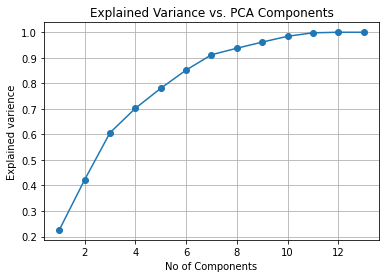

In [312]:
pca = PCA().fit(scaled_features)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("No of Components")
plt.ylabel("Explained varience")
plt.title("Explained Variance vs. PCA Components")
plt.grid(True)
plt.show()


## Performing PCA combined with k mean clustering

# K Mean clustering

In [313]:
optml_pca = 0
optml_k = 0 
prev = float('inf')
for i in range(1,14):
    db_values= []
    pca = PCA(n_components=i)
    reduced_features = pca.fit_transform(scaled_features)
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(reduced_features)
        db_values.append(davies_bouldin_score(reduced_features, labels))
    # print(db_values)
    k = np.argmin(db_values) + 2
    kmeans = KMeans(n_clusters=k,random_state=42)
    labels = kmeans.fit_predict(reduced_features)
    print("\n\nFor PCA components = "+str(i))
    print("Optimal number of clusters: "+str(k))
    print("DB Index :: "+str(davies_bouldin_score(reduced_features,labels)))
    print("Silhouette Score :: "+str(silhouette_score(reduced_features,labels)))
    print("CH index :: "+str(calinski_harabasz_score(reduced_features,labels)))
    db_min = min(db_values)
    if prev >= db_min:
        optml_k = k
        optml_pca = i
        prev = db_min
print("optimal pca compnents is :: ",optml_pca)
print("optimal no of clusters is :: ",optml_k)



For PCA components = 1
Optimal number of clusters: 2
DB Index :: 0.10745311536034093
Silhouette Score :: 0.9198091775555632
CH index :: 6285.646505901009


For PCA components = 2
Optimal number of clusters: 4
DB Index :: 0.1518499646620887
Silhouette Score :: 0.8985853305946186
CH index :: 17012.52693528158


For PCA components = 3
Optimal number of clusters: 4
DB Index :: 0.08532398168568392
Silhouette Score :: 0.939034069310377
CH index :: 11166.13426509781


For PCA components = 4
Optimal number of clusters: 4
DB Index :: 0.43246082170677697
Silhouette Score :: 0.7216527748784
CH index :: 396.3473893198873


For PCA components = 5
Optimal number of clusters: 4
DB Index :: 0.6177082125704082
Silhouette Score :: 0.6131712289643731
CH index :: 222.59783673695551


For PCA components = 6
Optimal number of clusters: 4
DB Index :: 0.755459458084225
Silhouette Score :: 0.5394495244218057
CH index :: 158.5524098879436


For PCA components = 7
Optimal number of clusters: 4
DB Index :: 0.85

In [314]:
print(optml_pca,optml_k)
pca = PCA(n_components=optml_pca)
features_reduction = pca.fit_transform(scaled_features)
kmeans = KMeans(n_clusters=optml_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(features_reduction)

3 4


In [315]:
customer_data.head()

,CustomerID,TotalSpent,Books_x,Clothing_x,Electronics_x,Home Decor_x,Books_y,Clothing_y,Electronics_y,Home Decor_y,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,3354.52,114.600000,0.00,942.433333,412.620000,1,0,3,1,0.0,0.0,0.0,1.0,1
1,C0002,1862.74,0.000000,512.73,0.000000,418.640000,0,2,0,2,1.0,0.0,0.0,0.0,3
2,C0003,2725.38,0.000000,122.36,1385.200000,608.910000,0,1,1,2,0.0,0.0,0.0,1.0,1
3,C0004,5354.88,629.493333,0.00,677.870000,703.553333,3,0,2,3,0.0,0.0,0.0,1.0,1
4,C0005,2034.24,0.000000,0.00,590.190000,853.860000,0,0,2,1,1.0,0.0,0.0,0.0,3


# Evaluation of the clusters 

In [316]:
# Cluster Evaluation using DB Index, silhouette score, calinski-harabasz index
db_index = davies_bouldin_score(features_reduction, customer_data['Cluster'])
silhouette = silhouette_score(features_reduction, customer_data['Cluster'])
ch_index = calinski_harabasz_score(features_reduction,customer_data['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"ch_index :: {ch_index}")


Davies-Bouldin Index: 0.08532398168568392
Silhouette Score: 0.939034069310377
ch_index :: 11166.13426509781


# Visualization

### Performing PCA for visualization

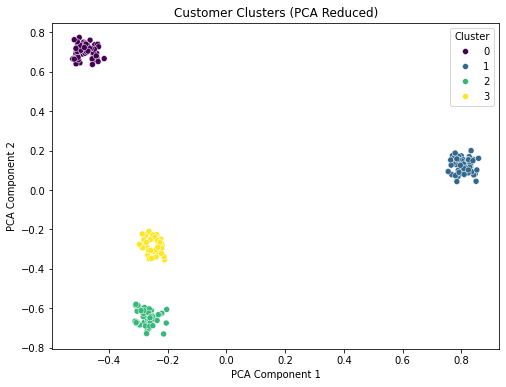

In [317]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

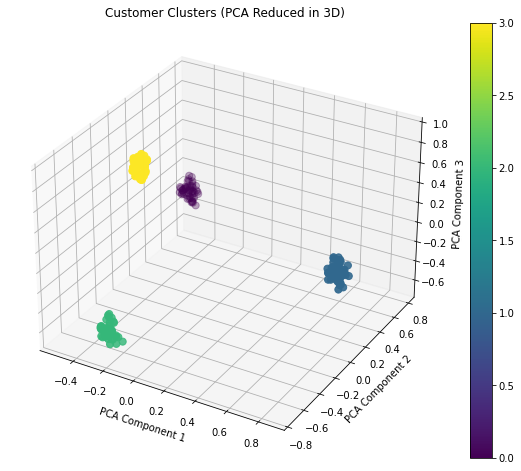

In [318]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(scaled_features)


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], 
                     c=customer_data['Cluster'], cmap='viridis', s=50)

ax.set_title('Customer Clusters (PCA Reduced in 3D)')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

plt.colorbar(scatter)


plt.show()
